In [74]:
"""第一步，进行数据的初步了解"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

path = r"C:\Users\11953\M2_ISDS\ML_PROJET\\"

data_train = pd.read_csv(path+"train.csv")
data_test = pd.read_csv(path+"test.csv")

In [75]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [76]:
missing_values = data_train.isnull().sum()
print(missing_values)

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [77]:
print(data_train.describe())

                 id           age  hypertension  heart_disease  \
count  15304.000000  15304.000000  15304.000000   15304.000000   
mean    7651.500000     41.417708      0.049726       0.023327   
std     4418.028595     21.444673      0.217384       0.150946   
min        0.000000      0.080000      0.000000       0.000000   
25%     3825.750000     26.000000      0.000000       0.000000   
50%     7651.500000     43.000000      0.000000       0.000000   
75%    11477.250000     57.000000      0.000000       0.000000   
max    15303.000000     82.000000      1.000000       1.000000   

       avg_glucose_level           bmi        stroke  
count       15304.000000  15304.000000  15304.000000  
mean           89.039853     28.112721      0.041296  
std            25.476102      6.722315      0.198981  
min            55.220000     10.300000      0.000000  
25%            74.900000     23.500000      0.000000  
50%            85.120000     27.600000      0.000000  
75%            96.98

In [78]:
print(data_train.columns)

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


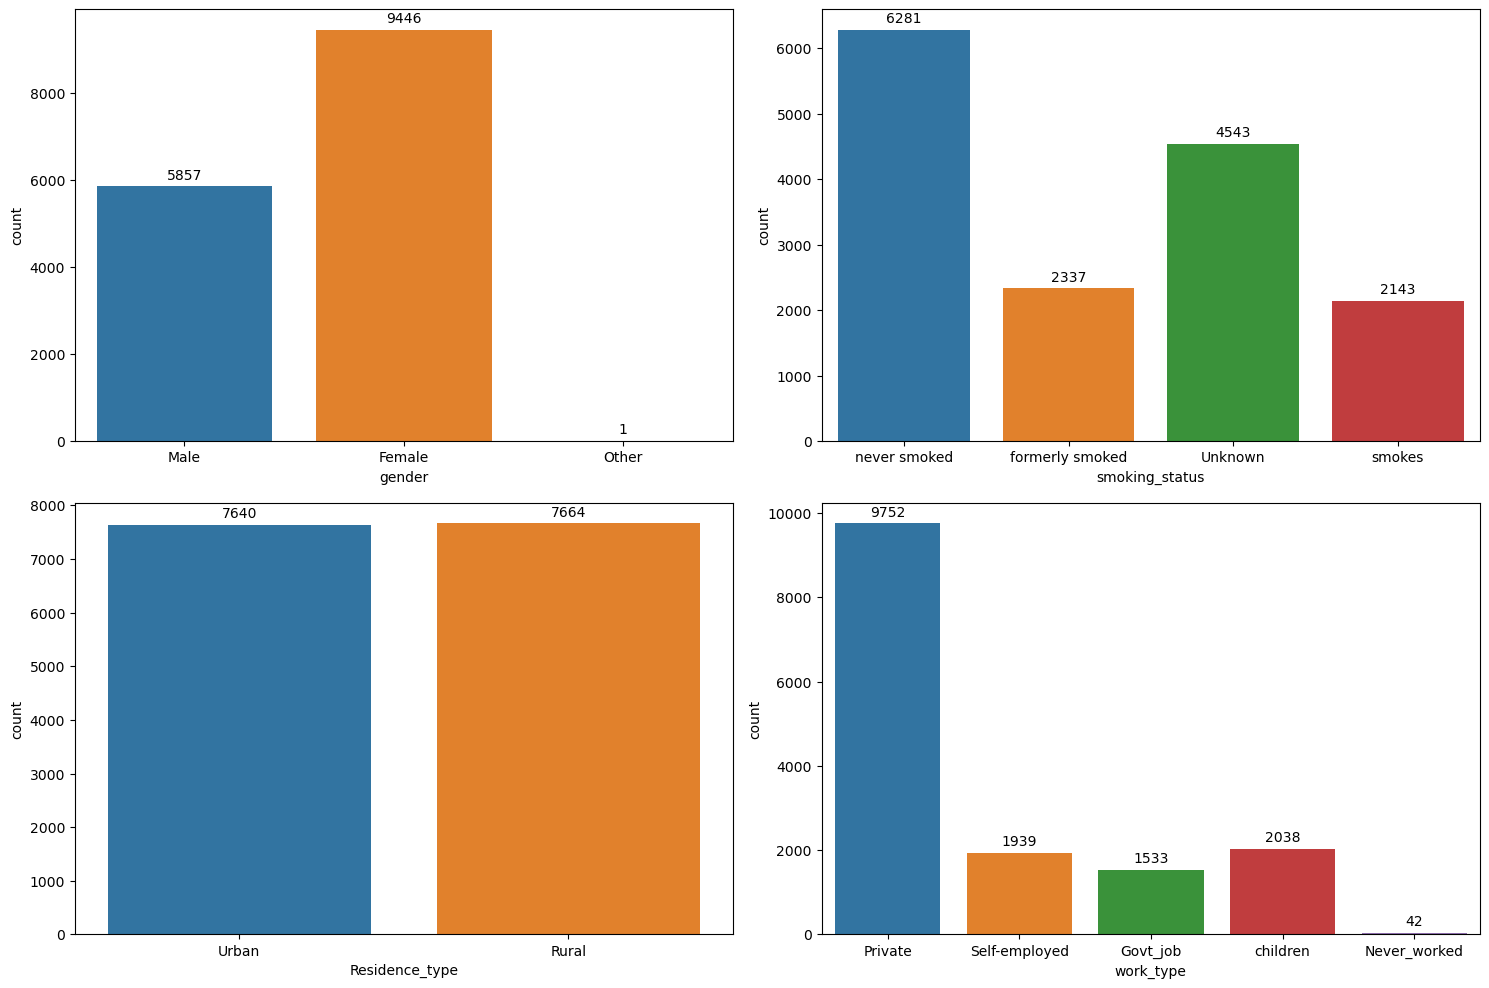

In [79]:
# 列分析，首先分析性别 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.countplot(data=data_train, x='gender', ax=axes[0, 0])
for bar in axes[0, 0].patches:
    axes[0, 0].annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 8), textcoords='offset points')

sns.countplot(data=data_train, x='smoking_status', ax=axes[0, 1])
for bar in axes[0, 1].patches:
    axes[0, 1].annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 8), textcoords='offset points')

sns.countplot(data=data_train, x='Residence_type', ax=axes[1, 0])
for bar in axes[1, 0].patches:
    axes[1, 0].annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 8), textcoords='offset points')

sns.countplot(data=data_train, x='work_type', ax=axes[1, 1])
for bar in axes[1, 1].patches:
    axes[1, 1].annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 8), textcoords='offset points')

plt.tight_layout()
plt.show()

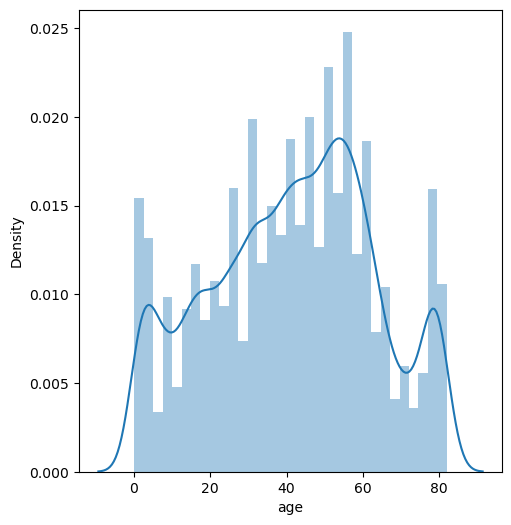

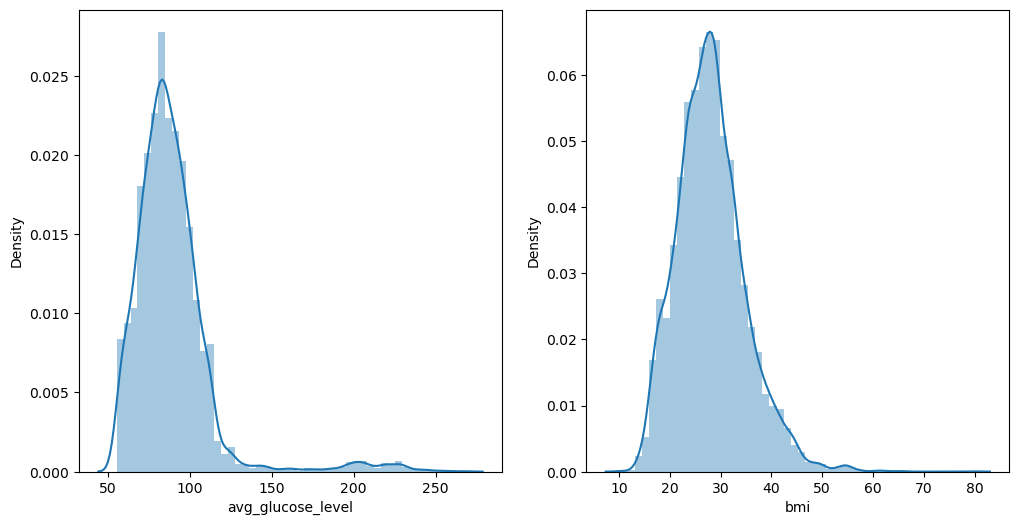

In [80]:
# 之后分析其他列的数据分布情况
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.distplot(data_train['age'])
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.distplot(data_train['avg_glucose_level'])
plt.subplot(1, 2, 2)
sns.distplot(data_train['bmi'])
plt.show()


In [81]:
# 删除不确定的值
data_train = data_train[data_train['smoking_status'] != 'Unknown']
data_train = data_train[data_train['gender'] != 'Other']

In [82]:
# 在确定了我们的数据库中没有异常值之后，我们就可以进行classification的建模了
# 分类特征和数值特征
X = data_train.drop(['id', 'stroke'], axis=1)
y = data_train['stroke']
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns


In [83]:
# 构建预处理管道
# 对数值特征进行标准化
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


In [84]:
# 对分类特征进行独热编码
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [85]:
# 合并处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [86]:
# 应用预处理并分割数据集
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, data_train['stroke'], test_size=0.2, random_state=42)


In [87]:
# 初始化模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000),
    "Random Forest" : RandomForestClassifier(),
    "XG Boosting" : XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# 训练模型并评估
results = {}
for name, model in models.items():

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # 存储结果
    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

results

{'Logistic Regression': {'Accuracy': 0.9498374361356247,
  'Precision': 0.9314474230488679,
  'Recall': 0.9498374361356247,
  'F1 Score': 0.9291809969421251},
 'K-Nearest Neighbors': {'Accuracy': 0.9433348815606131,
  'Precision': 0.9102094771441812,
  'Recall': 0.9433348815606131,
  'F1 Score': 0.9240238740593074},
 'Decision Tree': {'Accuracy': 0.910822108685555,
  'Precision': 0.9194104514642504,
  'Recall': 0.910822108685555,
  'F1 Score': 0.9149808323377456},
 'Support Vector Machine': {'Accuracy': 0.9493729679516953,
  'Precision': 0.9013090322774107,
  'Recall': 0.9493729679516953,
  'F1 Score': 0.924716867521213},
 'Naive Bayes': {'Accuracy': 0.24198792382721784,
  'Precision': 0.9389543987248582,
  'Recall': 0.24198792382721784,
  'F1 Score': 0.32726082335487605},
 'Neural Network': {'Accuracy': 0.9479795633999071,
  'Precision': 0.9227071516413491,
  'Recall': 0.9479795633999071,
  'F1 Score': 0.9281092991486225},
 'Random Forest': {'Accuracy': 0.9475150952159777,
  'Precisio